In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining some useful global variables

Next you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.


- `MAX_LENGTH`: Maximum length of all sequences. Defaults to 32.

    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.9

- `NUM_BATCHES`: Number of batches. Defaults to 128



In [2]:
EMBEDDING_DIM = 100
MAX_LENGTH = 32
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128
TEST_SPLIT_FROM_TRAIN = 0.05

## Import dataset and cleaning data

In [3]:
data_path = "/content/drive/MyDrive/Bangkit/Capstone/mental_health_conversations.csv"
df = pd.read_csv(data_path, header=None)
df.head()

,0,1,2
0,NaN,statement,status
1,0.0,oh my gosh,Anxiety
2,1.0,"trouble sleeping, confused mind, restless hear...",Anxiety
3,2.0,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
4,3.0,I've shifted my focus to something else but I'...,Anxiety


In [4]:
df = df.drop(index=0)

# Reset index if needed
df.reset_index(drop=True, inplace=True)

df.head()

,0,1,2
0,0.0,oh my gosh,Anxiety
1,1.0,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2.0,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3.0,I've shifted my focus to something else but I'...,Anxiety
4,4.0,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       53043 non-null  float64
 1   1       52681 non-null  object 
 2   2       53043 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [6]:
df.dropna(inplace = True)
df.isna().sum()

,0
0,0
1,0
2,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       52681 non-null  float64
 1   1       52681 non-null  object 
 2   2       52681 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [8]:
statuses = df[2].unique()
print(statuses)
print(len(statuses))

['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']
7


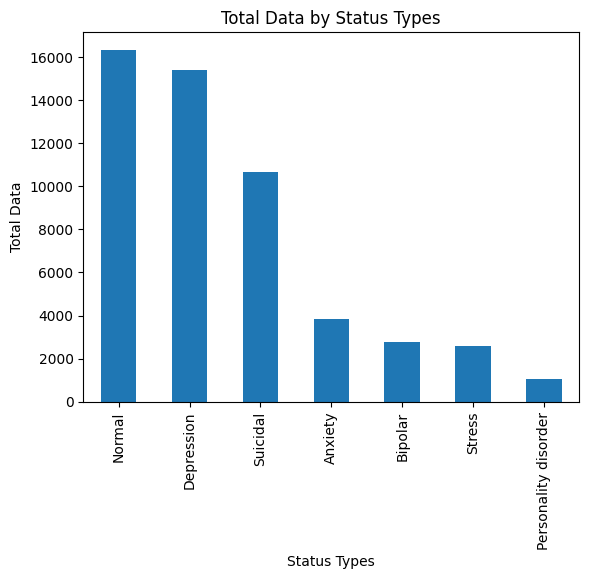

In [9]:
df[2].value_counts().plot(kind='bar')
plt.xlabel("Status Types")
plt.ylabel("Total Data")
plt.title("Total Data by Status Types")
plt.show()

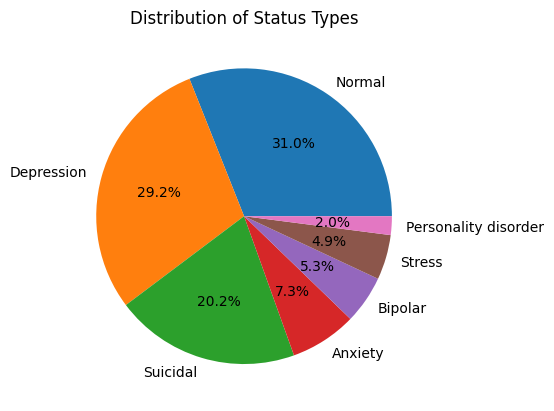

In [10]:
# Assuming df is already loaded as in the provided code
df[2].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Distribution of Status Types")
plt.ylabel("")  # Remove the y-axis label
plt.show()

In [11]:
# Standardize labels so they have
# 'Anxiety'              => 0
# 'Normal'               => 1
# 'Depression'           => 2
# 'Suicidal'             => 3
# 'Stress'               => 4
# 'Bipolar'              => 5
# 'Personality disorder' => 6
status_mapping = {
    'Anxiety': 0,
    'Normal': 1,
    'Depression': 2,
    'Suicidal': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}
labels = df[2].apply(lambda x: status_mapping.get(x, -1)).to_numpy()  # Default to -1 if the value is not in the mapping

# Since the original dataset does not provide headers you need to index the columns by their index
sentences = df[1].to_numpy()

print(sentences[:5])
print(labels[:5])


['oh my gosh'
 'trouble sleeping, confused mind, restless heart. All out of tune'
 'All wrong, back off dear, forward doubt. Stay in a restless and restless place'
 "I've shifted my focus to something else but I'm still worried"
 "I'm restless and restless, it's been a month now, boy. What do you mean?"]
[0 0 0 0 0]


In [40]:
# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))
dataset = dataset.shuffle(buffer_size=len(sentences), seed=42)  # Shuffle using the number of sentences

# Compute sizes for each split
dataset_size = len(sentences)
train_size = int(dataset_size * TRAINING_SPLIT)
test_size = int(train_size * TEST_SPLIT_FROM_TRAIN)
adjusted_train_size = train_size - test_size
val_size = dataset_size - train_size

# Split the dataset
test_dataset = dataset.skip(adjusted_train_size).take(test_size)  # Test data

# Batch the datasets
dataset = dataset.batch(NUM_BATCHES)
test_dataset = test_dataset.batch(NUM_BATCHES)

# Get the first 5 elements of the dataset
examples = list(dataset.take(5))

print(f"Dataset contains {dataset_size} examples")

# Print labels of the first 5 examples
print(f"Labels of first 5 examples look like this: {[x[1].numpy() for x in examples]}")

Dataset contains 52681 examples
Labels of first 5 examples look like this: [array([3, 2, 2, 3, 3, 3, 4, 1, 0, 0, 1, 1, 3, 5, 3, 0, 0, 1, 2, 3, 1, 0,
       1, 1, 1, 0, 1, 2, 2, 6, 3, 1, 3, 5, 2, 3, 0, 2, 3, 2, 0, 2, 1, 3,
       2, 1, 5, 4, 2, 1, 3, 5, 1, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 3, 0, 0,
       2, 1, 1, 1, 4, 4, 1, 1, 4, 1, 2, 3, 0, 3, 1, 1, 2, 3, 3, 3, 2, 4,
       3, 3, 5, 3, 1, 2, 3, 1, 2, 0, 5, 2, 4, 1, 3, 3, 2, 2, 2, 3, 4, 2,
       0, 1, 5, 3, 2, 3, 1, 3, 3, 1, 1, 2, 6, 1, 3, 6, 0, 2]), array([1, 2, 3, 2, 3, 1, 1, 3, 3, 3, 2, 2, 2, 2, 0, 5, 2, 2, 0, 2, 1, 2,
       3, 3, 2, 1, 3, 2, 2, 2, 2, 1, 2, 1, 1, 2, 3, 1, 2, 1, 1, 2, 0, 2,
       4, 6, 2, 3, 3, 3, 1, 4, 2, 2, 1, 1, 5, 1, 1, 3, 1, 1, 1, 2, 2, 3,
       0, 1, 3, 2, 3, 2, 2, 2, 2, 1, 0, 3, 1, 1, 3, 2, 3, 2, 2, 3, 2, 5,
       2, 2, 3, 6, 1, 1, 2, 2, 3, 3, 2, 5, 3, 2, 3, 3, 1, 1, 2, 2, 0, 2,
       2, 5, 3, 2, 2, 1, 5, 1, 2, 2, 2, 1, 1, 0, 1, 3, 2, 0]), array([2, 1, 3, 2, 3, 3, 4, 2, 1, 1, 2, 3, 3, 3, 1, 3, 1, 2, 1, 2, 2

In [13]:
print(len(test_dataset))
print(adjusted_train_size)

19
45042


In [14]:
def fit_vectorizer(dataset):
  vectorizer = tf.keras.layers.TextVectorization(
      standardize='lower_and_strip_punctuation',
      output_mode='int',
      output_sequence_length=MAX_LENGTH
  )

  vectorizer.adapt(dataset)

  return vectorizer

In [15]:
print(f"There are {len(dataset)} batches for a total of {NUM_BATCHES*len(dataset)} elements for training.\n")

There are 412 batches for a total of 52736 elements for training.



In [16]:
text_only_dataset = dataset.map(lambda text, label: text)

vectorizer = fit_vectorizer(text_only_dataset)

vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 81296 words



In [17]:
def train_val_test_datasets(dataset, batch_size):
    dataset_size = len(dataset)

    dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

    # Compute sizes for each split
    train_size = int(dataset_size * TRAINING_SPLIT)
    val_size = dataset_size - train_size
    test_size = int(train_size * TEST_SPLIT_FROM_TRAIN)
    adjusted_train_size = train_size - test_size

    # Split the dataset
    train_dataset = dataset.take(adjusted_train_size)  # Remaining training data
    test_dataset = dataset.skip(adjusted_train_size).take(test_size)  # Test data
    val_dataset = dataset.skip(adjusted_train_size + test_size)  # Validation data

    # Batch the datasets
    train_dataset = train_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset, test_dataset

In [18]:
# prompt: convert variable vectorizer to numpy and apply smote oversampling than convert again to tensor dataset than split it to train, val and tes

from imblearn.over_sampling import SMOTE

# Convert the TensorFlow dataset to NumPy arrays
sentences_np = []
labels_np = []
for text, label in dataset:
    sentences_np.extend(text.numpy())
    labels_np.extend(label.numpy())

sentences_np = np.array(sentences_np)
labels_np = np.array(labels_np)

# Apply SMOTE oversampling
smote = SMOTE(random_state=42)
sentences_resampled, labels_resampled = smote.fit_resample(vectorizer(sentences_np).numpy(), labels_np)

# Convert back to TensorFlow dataset
resampled_dataset = tf.data.Dataset.from_tensor_slices((sentences_resampled, labels_resampled))

train_dataset_vectorized, val_dataset_vectorized, _ = train_val_test_datasets(resampled_dataset, NUM_BATCHES)

In [19]:
print(f"There are {len(train_dataset_vectorized)} batches for a total of {NUM_BATCHES*len(train_dataset_vectorized)} elements for training.\n")
print(f"There are {len(val_dataset_vectorized)} batches for a total of {NUM_BATCHES*len(val_dataset_vectorized)} elements for validation.\n")
print(f"There are {len(test_dataset)} batches for a total of {NUM_BATCHES*len(test_dataset)} elements for test.\n")

There are 765 batches for a total of 97920 elements for training.

There are 90 batches for a total of 11520 elements for validation.

There are 19 batches for a total of 2432 elements for test.



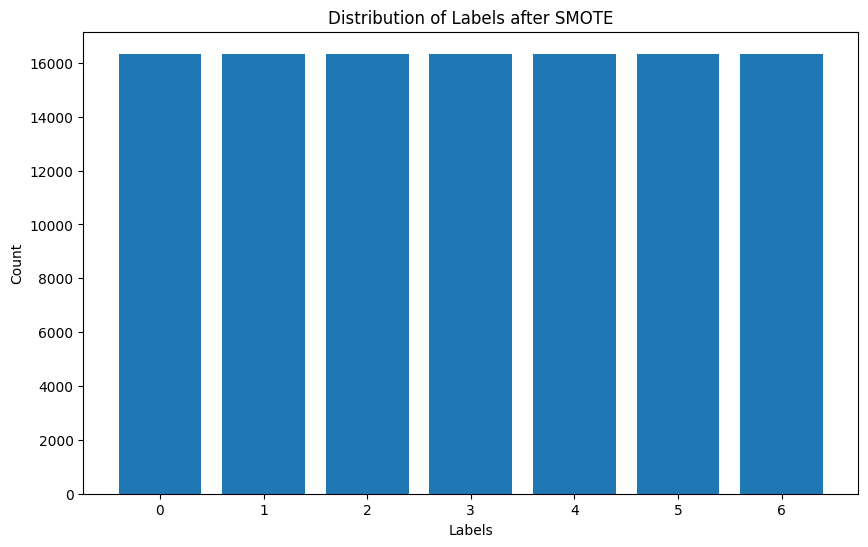

In [20]:
# prompt: create bar chart from variable train_dataset_vectorized

import matplotlib.pyplot as plt

# Assuming labels_resampled contains the resampled labels
unique_labels, label_counts = np.unique(labels_resampled, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Distribution of Labels after SMOTE")
plt.xticks(unique_labels)  # Ensure all labels are displayed on the x-axis
plt.show()

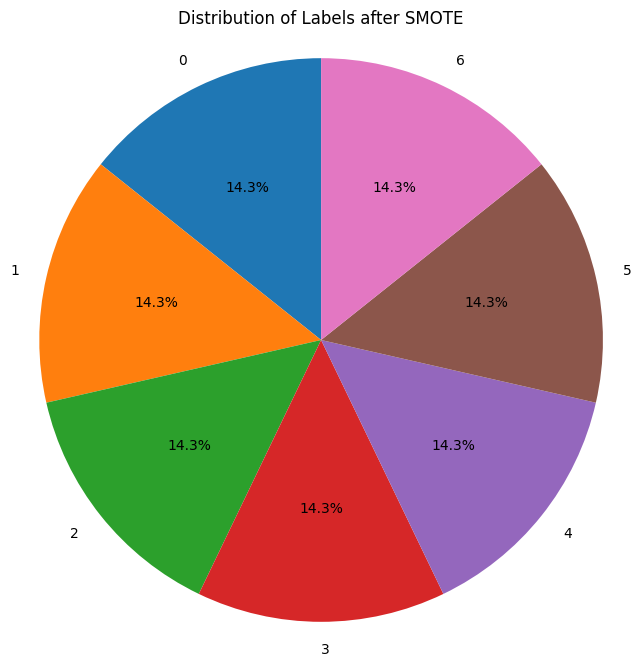

In [21]:
# prompt: create pie chart from variable train_dataset_vectorized

# Assuming labels_resampled contains the resampled labels
unique_labels, label_counts = np.unique(labels_resampled, return_counts=True)

plt.figure(figsize=(8, 8))  # Adjust figure size for better visualization
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Labels after SMOTE")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [22]:
train_dataset, val_dataset, test_dataset = train_val_test_datasets(dataset, NUM_BATCHES)

print(f"There are {len(train_dataset)} batches for a total of {NUM_BATCHES*len(train_dataset)} elements for training.\n")
print(f"There are {len(val_dataset)} batches for a total of {NUM_BATCHES*len(val_dataset)} elements for validation.\n")
print(f"There are {len(test_dataset)} batches for a total of {NUM_BATCHES*len(test_dataset)} elements for test.\n")

There are 3 batches for a total of 384 elements for training.

There are 1 batches for a total of 128 elements for validation.

There are 1 batches for a total of 128 elements for test.



In [23]:
glove_file = '/content/drive/MyDrive/Bangkit/Capstone/Files/tf/data/glove.6B.100d.txt'

glove_embeddings = {}

with open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

In [24]:
test_word = 'dog'

test_vector = glove_embeddings[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [25]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


In [26]:
word_index = {x:i for i, x in enumerate(vectorizer.get_vocabulary())}

print(f"The word dog is encoded as: {word_index['dog']}")

The word dog is encoded as: 662


In [27]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, index in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [28]:
test_word = 'dog'

test_word_id = word_index[test_word]

test_vector_dog = glove_embeddings[test_word]

test_embedding_dog = embedding_matrix[test_word_id]

both_equal = np.allclose(test_vector_dog, test_embedding_dog)

print(f"word: {test_word}, index: {test_word_id}\n\nEmbedding is equal to column {test_word_id} in the embeddings_matrix: {both_equal}")

word: dog, index: 662

Embedding is equal to column 662 in the embeddings_matrix: True


In [29]:
def create_model(vocab_size, pretrained_embeddings):
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(MAX_LENGTH,)),

      tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=pretrained_embeddings.shape[1]),

      tf.keras.layers.LSTM(units=64, return_sequences=True),

      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.GlobalMaxPooling1D(),

      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dense(units=7, activation='softmax')
  ])

  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  return model

In [30]:
model = create_model(vocab_size, embedding_matrix)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 32, 100)             │       8,129,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32, 64)              │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,176,455 (31.19 MB)

 Trainable params: 8,176,455 (31.19 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Take an example batch of data
example_batch = train_dataset_vectorized.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 7)


In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=0.99,
)

In [33]:
history = model.fit(
    train_dataset_vectorized,
    validation_data=val_dataset_vectorized,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.3835 - loss: 1.4742 - val_accuracy: 0.5157 - val_loss: 1.2892
Epoch 2/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.5205 - loss: 1.1539 - val_accuracy: 0.5859 - val_loss: 1.1631
Epoch 3/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5855 - loss: 1.0258 - val_accuracy: 0.6390 - val_loss: 1.0581
Epoch 4/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6318 - loss: 0.9258 - val_accuracy: 0.6839 - val_loss: 0.9656
Epoch 5/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6792 - loss: 0.8160 - val_accuracy: 0.7401 - val_loss: 0.8468
Epoch 6/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7272 - loss: 0.7082 - val_accuracy: 0.7809 - val_loss: 0.7332
Epoch 7/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7610 - loss: 0.6249 - val_accuracy: 0.8116 - val_loss: 0.6541
Epoch 8/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7922 - loss: 0.5464 - val_

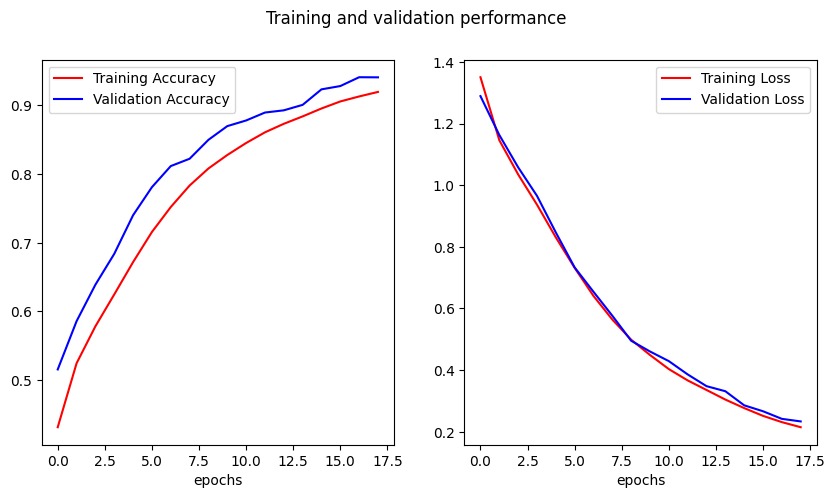

In [34]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

In [35]:
embedding = model.layers[0]

with open('./metadata.tsv', "w") as f:
    for word in vectorizer.get_vocabulary():
        f.write("{}\n".format(word))
weights = tf.Variable(embedding.get_weights()[0][1:])

with open('./weights.tsv', 'w') as f:
    for w in weights:
        f.write('\t'.join([str(x) for x in w.numpy()]) + "\n")

## Save Model

In [41]:
export_model = tf.keras.Sequential([
    vectorizer,
    model,
    tf.keras.layers.Activation('softmax')
])

export_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

metrics = export_model.evaluate(test_dataset, return_dict=True)
print(metrics)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9718 - loss: 0.0000e+00
{'accuracy': 0.9704641103744507, 'loss': 0.0}


In [42]:
export_model.save('mental_health_2.keras')

## Load Model

In [ ]:
laoded_model_w_vectorizer = tf.keras.models.load_model('/content/mental_health_2 (1).keras')

In [ ]:
new_texts = [
    "Going on a long vacation, 21 days, with a big time change. Time change and taking meds question. So I have all my meds filled and enough for the trip + afterwards. I typically take my meds at 8pm every night and right before bed. I’m very good at taking my meds on time I really don’t miss them, so I just want to be safe when it comes to being in a different time zone. Do I take them at the same in the other country, or do I take them at the same time I would while there? And any tips from you guys about traveling. I’m a bit nervous to step out of my really good routine and sleep schedule and be traveling to multiple countries. My therapist/prescribing nurse have confidence in me and support this trip too.	",
    "I'm sure that today, the one who came to the school hall, Mr. Madam, is proud, mmf, isn't your son, hey, or his brain is thin...",
    "Panic Attacks Hi, I've been having very bad anxiety attacks lately. I've been taking valium and it's helped but doesn't eliminate it. I've never had it sooooo bad. I also take olanzapine. I'm in the gym trying to push it away but I want to run home and take a valium. However, I only have a few tablets left. I'm really struggling on what to do. Anyone else feel the same or have been in a similar place?",
    "i feel happy",
    "i feel very happy",
    # "I am feeling great today!",
    # "I am so stressed out",
    # "It just felt like a storm, rumbling, boisterous, restless and quite stifling.",
    # "It's been a long time since I've been here, I'm suddenly restless + crazy chest pain",
]
new_texts_tensor = tf.convert_to_tensor(new_texts)

predictions = laoded_model_w_vectorizer.predict(new_texts_tensor)
print(predictions)

class_labels = ['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar', 'Personality disorder']

for pred in predictions:
  predicted_class = np.argmax(pred, axis=-1)
  predicted_label = class_labels[predicted_class]

  print(f"Predicted class: {predicted_label}")